In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr

import numpyro
import numpyro.distributions as dist

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from ent_likelihood import Likelihood
from samples import Samples
import constants as c

from ent_data_simulation import params_injected

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# load Enterprise pulsar data
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
toas = jnp.array(data_dict['toas'])
residuals = jnp.array(data_dict['residuals'])
Tspans = toas[:, -1] - toas[:, 0]
Np = toas.shape[0]
Ntoas = toas.shape[1]
Fs = jnp.array(data_dict['Fs'])
Ms = jnp.array(data_dict['Ms'])
Rs = jnp.array([jnp.eye(Ntoas) - M @ jnp.linalg.inv(M.T @ M) @ M.T
                for M in Ms])
U_s = jnp.array([jnp.linalg.svd(M)[0]
                 for M in Ms])
Gs = jnp.array([U[:, 8:] for U in U_s])
Ns = jnp.array(data_dict['Ns'])
Ntinvs = jnp.array([G @ jnp.linalg.inv(G.T @ N @ G) @ G.T
                    for G, N in zip(Gs, Ns)])
psr_names = data_dict['psr_names']
x_inj_dict = data_dict['x_inj'].item()

Np = toas.shape[0]
Ntoas = toas.shape[1]
Nf = params_injected.num_modes
Na = 2 * Nf

In [3]:
rho_scales = []
arrs = []
for Tspan in Tspans:
    rho_scale = (c.year_sec ** 3.) / (12. * (jnp.pi ** 2.) * Tspan)
    rho_scale1 = Tspan / c.year_sec
    arr = jnp.repeat(jnp.arange(1, Nf + 1), 2)
    arr /= rho_scale1
    arr = jnp.array(arr)
    rho_scales.append(rho_scale)
    arrs.append(arr)
rho_scales = jnp.array(rho_scales)
arrs = jnp.array(arrs)


@jit
def get_rho_diag(hyper_params, rho_scale, arr):
    logAmp, gamma = hyper_params
    Amp = 10. ** logAmp
    return (Amp ** 2.) * rho_scale * (arr **  (-gamma))

vectorized_get_rho_diag_full_input = jit(vmap(get_rho_diag, in_axes=(0, 0, 0)))

@jit
def vectorized_get_rho_diag(hyper_params):
    return vectorized_get_rho_diag_full_input(hyper_params, rho_scales, arrs)


In [4]:
Us = jnp.array([res.T @ Ntinv @ res for res, Ntinv in zip(residuals, Ntinvs)])
Vs = jnp.array([F.T @ Ntinv @ res for F, Ntinv, res in zip(Fs, Ntinvs, residuals)])
Ws = jnp.array([F.T @ Ntinv @ F for F, Ntinv in zip(Fs, Ntinvs)])

@jit
def lnlike_per_pulsar(a, U, V, W):
    return -0.5 * (U + a.T @ W @ a - 2 * jnp.inner(a, V))
vectorized_lnlike_per_pulsar = jit(vmap(lnlike_per_pulsar, in_axes=(0, 0, 0, 0)))

@jit
def lnlike(a):
    a_stacked = a.reshape((Np, Na))
    return jnp.sum(vectorized_lnlike_per_pulsar(a_stacked, Us, Vs, Ws))

In [5]:
a_ML = jnp.array([jnp.linalg.pinv(F) @ res for F, res in zip(Fs, residuals)]).flatten()
print(lnlike(a_ML))

-1419.586730306566


In [6]:
%timeit lnlike(a_ML)

8.73 μs ± 525 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
hyper_mins = jnp.tile(jnp.array([-20., 0.]), (Np, 1)).flatten()
hyper_maxs = jnp.tile(jnp.array([-10., 9.]), (Np, 1)).flatten()

def sampling_model():
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(hyper_mins, hyper_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand((Np * Na,)))
    scale = jnp.sqrt(vectorized_get_rho_diag(rn_hypers.reshape((Np, 2)))).flatten()
    a = scale * a_standard
    a = numpyro.deterministic('a', a)

    # likelihood
    numpyro.factor('ln_likelihood', lnlike(a))

In [8]:
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True,
                                 )
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e5),
                          num_samples=int(2e5))
mcmc.run(jr.key(11))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 300000/300000 [06:37<00:00, 754.52it/s, 127 steps of size 2.78e-02. acc. prob=0.88] 


In [12]:
# isolate red noise hyper-parameter samples and labels
rn_samples = samples_dict['rn_hypers']
rn_labels = np.array([[f'{psr_name}_red_noise_log10_A', f'{psr_name}_red_noise_gamma']
                      for psr_name in psr_names]).flatten()

# load samples from Enterprise run
ent_samples_dict = dict(np.load('ent_samples_dict.npz', allow_pickle=True))

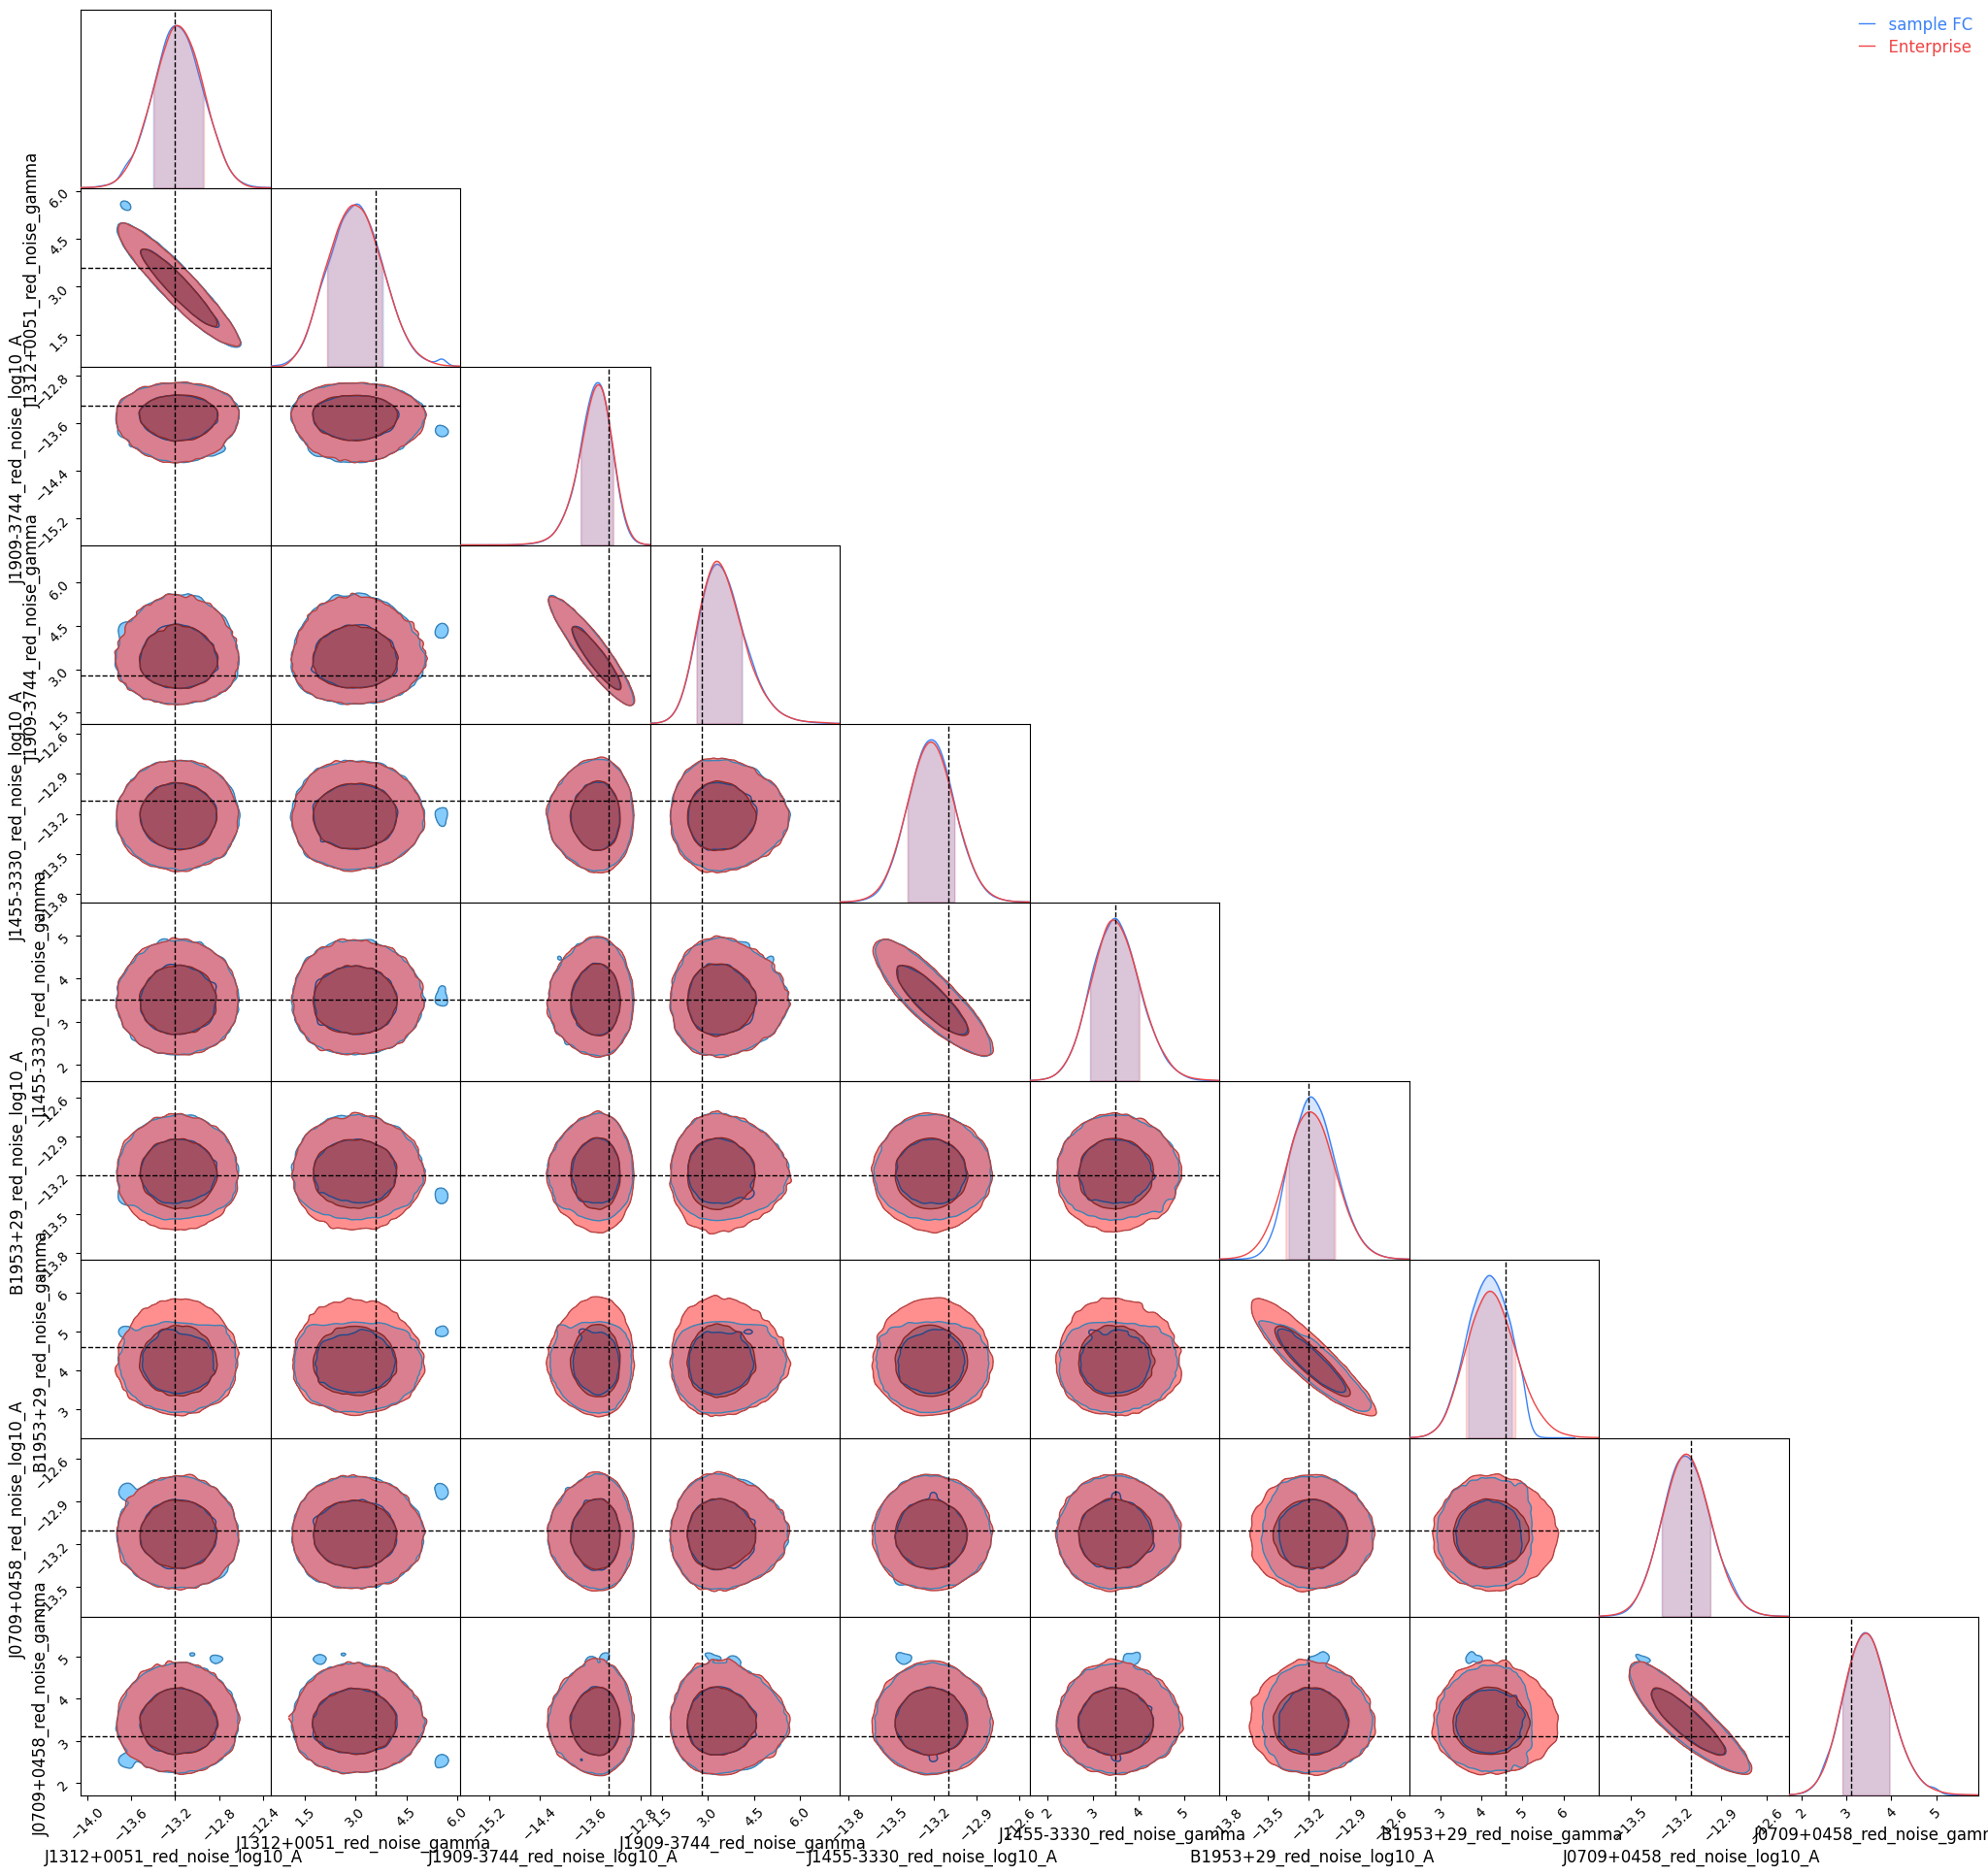

In [13]:
# corner plot
ndxs = np.r_[:10]
df = pd.DataFrame(rn_samples, columns=rn_labels)
df_ent = pd.DataFrame(ent_samples_dict)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='sample FC'))
c.add_chain(Chain(samples=df_ent.iloc[:, ndxs], name='Enterprise', color='red'))
c.add_truth(Truth(location=x_inj_dict))
fig = c.plotter.plot()

In [11]:
# # Bayesogram
# psr_ndx = 0
# fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (1000,))

# # percentile layers for plotting densities of samples
# percentile_layers = [0.15, 2.5, 16.]
# alphas = [0.2, 0.5, 0.7]

# # plot data, samples, and injected signals
# plt.figure(figsize=(10, 4))
# plt.scatter(data_dict['toas'][psr_ndx] / 86400., data_dict['residuals'][psr_ndx], s=15)
# plt.xlabel('TOAs (MJD)')
# plt.ylabel('timing residuals (s)')

# rn_gwb_signals = np.array([R[psr_ndx] @ data_dict['Fs'][psr_ndx] @ samples_arr[ndx, 2:].reshape((pta_for_parameters.Np, pta_for_parameters.Na))[psr_ndx]
#                             for ndx in fair_draw_ndxs])
# for percentile, alpha in zip(percentile_layers, alphas):
#     if percentile != percentile_layers[-1]:
#         plt.fill_between(data_dict['toas'][psr_ndx] / 86400., np.percentile(rn_gwb_signals, percentile, axis=0),
#                         np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
#                         color='orange', alpha=alpha)
#     else:
#         plt.fill_between(data_dict['toas'][psr_ndx] / 86400., np.percentile(rn_gwb_signals, percentile, axis=0),
#                         np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
#                         color='orange', alpha=alpha, label='RN + GWB samples')

# plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
# plt.ylabel('residuals [s]')
# plt.legend()
# plt.grid()
# plt.show()